In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import Sky_area_generator

In [2]:
runName = 'north_stripe_v2.0_10yrs'
opsdb = os.path.join('.', runName + '.db')

In [3]:
filterlist, colors, orders, sqls, info_labels = maf.batches.filterList(all=True)
print(filterlist)

nside = 64
slicer = maf.HealpixSlicer(nside=nside)

bundles = {}
for f in filterlist:
    bundles[f'nvisits {f}'] = maf.MetricBundle(metric=maf.CountMetric(col='observationStartMJD', metricName=f'Nvisits {f}'),
                                 slicer=slicer,
                                 constraint=sqls[f],
                                 info_label=info_labels[f],
                                 runName=runName)
    bundles[f'coadd {f}'] = maf.MetricBundle(metric=maf.Coaddm5Metric(),
                                 slicer=slicer,
                                 constraint=sqls[f],
                                 info_label=info_labels[f],
                                 runName=runName)

('all', 'u', 'g', 'r', 'i', 'z', 'y')
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [4]:
outDir = 'north_stripe_out'
g = maf.MetricBundleGroup(bundles, opsdb, outDir=outDir)
g.runAll()

Querying table None with no constraint for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'observationStartMJD', 'rotSkyPos'].
Found 2089053 visits
Running:  ['nvisits all', 'coadd all']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "y" for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'observationStartMJD', 'rotSkyPos']
Found 397896 visits
Running:  ['nvisits y', 'coadd y']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "r" for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'observationStartMJD', 'rotSkyPos']
Found 461207 visits
Running:  ['nvisits r', 'coadd r']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "g" for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'observationStartMJD', 'rotSkyPos']
Found 2

In [5]:
ph = maf.PlotHandler(outDir=outDir, thumbnail=False, figformat='png')

1

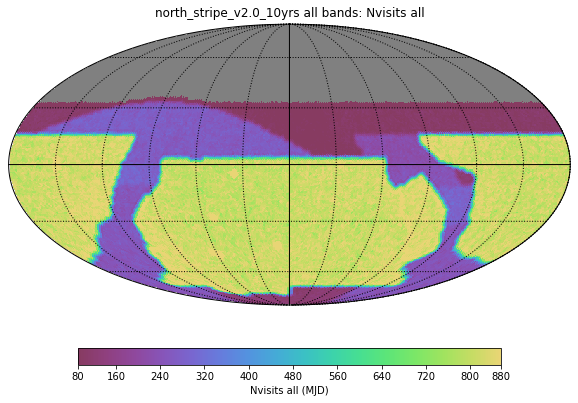

In [6]:
ph.setMetricBundles([bundles['nvisits all']])
ph.plot(maf.HealpixSkyMap(), plotDicts={'percentileClip': 90, 'figsize': (8, 6)})

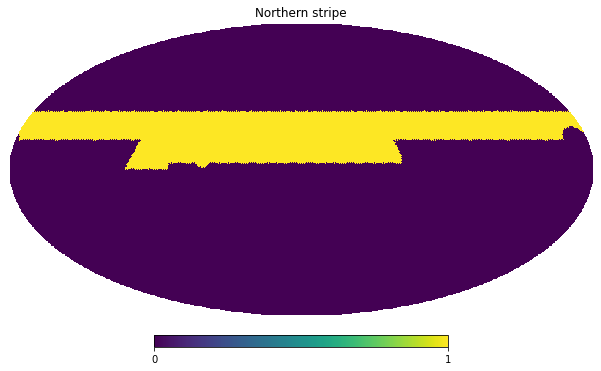

In [7]:
# We could figure out what the pixels are for the northern stripe in a few ways.. but can also use the footprint

sky = Sky_area_generator(nside=nside)
maps, labels = sky.return_maps()

# identify and add northern sky area - include NES
northern_stripe = np.where(sky.dec <= 30, 1, 0)
indx = np.where((northern_stripe > 0) & ((sky.pix_labels == "") | (sky.pix_labels == "nes")), 1, 0)

hp.mollview(np.where(indx, 1, 0), title= "Northern stripe")

In [8]:
north = {}
for b in bundles:
    north[b] = copy.deepcopy(bundles[b])
    north[b].metricValues.mask[np.where(indx==0)] = True

1

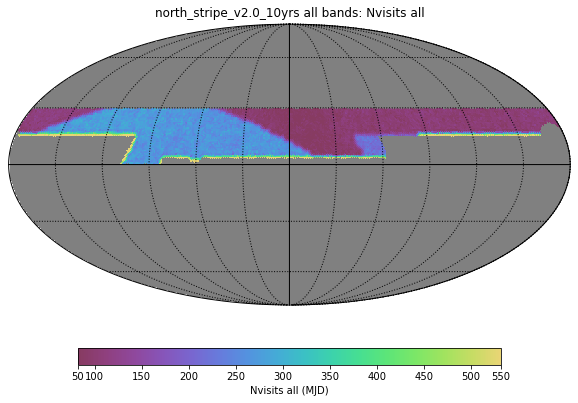

In [12]:
ph.setMetricBundles([north['nvisits all']])
ph.plot(maf.HealpixSkyMap(), plotDicts={'percentileClip': 95, 'figsize': (8, 6)})

In [10]:
summary_stats = [maf.MedianMetric(), maf.MeanMetric(), maf.PercentileMetric(percentile=25)]
for b in north:
    north[b].summaryValues = {}
    north[b].setSummaryMetrics(summary_stats)
    north[b].computeSummaryStats()
for b in bundles:
    bundles[b].summaryValues = {}
    bundles[b].setSummaryMetrics(summary_stats)
    bundles[b].computeSummaryStats()

In [11]:
keys = [f'nvisits {f}' for f in filterlist] + [f'coadd {f}' for f in filterlist]
dn = pd.DataFrame([north[b].summaryValues for b in keys], index=keys)
db = pd.DataFrame([bundles[b].summaryValues for b in keys], index=keys)
db.join(dn, lsuffix=' All sky', rsuffix=' North')

,Median All sky,Mean All sky,25th%ile All sky,Median North,Mean North,25th%ile North
nvisits all,789.000000,597.576016,254.000000,196.000000,201.100727,101.000000
nvisits u,49.000000,40.612261,18.000000,15.000000,15.912080,13.000000
nvisits g,66.000000,62.878639,44.000000,31.000000,31.091491,16.000000
nvisits r,170.000000,132.227479,57.000000,45.000000,45.966753,17.000000
nvisits i,172.000000,134.285005,60.000000,46.000000,46.894594,17.000000
nvisits z,153.000000,115.059825,45.000000,35.000000,34.770718,16.000000
nvisits y,156.000000,114.500949,26.000000,21.000000,26.465091,18.000000
coadd all,27.233540,26.952082,26.707266,26.322454,26.285562,25.903672
coadd u,25.697206,25.444593,25.028949,24.723650,24.740470,24.530101
coadd g,26.683777,26.496228,26.338050,25.937661,25.917204,25.575535


In [16]:
# What fraction of visits were used for the northern stripe? 
# probably want to discount NES visits .. so let's actually make a few versions 
indx_uy = np.where((northern_stripe > 0) & ((sky.pix_labels == "") | (sky.pix_labels == "nes")), 1, 0)
indx_griz = np.where((northern_stripe > 0) & (sky.pix_labels == ""), 1, 0)

visits = maf.getSimData(opsdb, None, dbcols=['fieldRA', 'fieldDec', 'observationStartMJD', 'night', 
                                             'filter', 'rotSkyPos', 'note'])

In [17]:
pd.DataFrame(visits).head()

,fieldRA,fieldDec,observationStartMJD,night,filter,rotSkyPos,note
0,310.024480,-60.812928,60218.001806,0,y,62.750775,"blob_twi, yy, a"
1,310.601871,-63.561425,60218.002254,0,y,61.084250,"blob_twi, yy, a"
2,311.292611,-66.317774,60218.002703,0,y,60.726189,"blob_twi, yy, a"
3,312.140731,-69.082666,60218.003152,0,y,60.656781,"blob_twi, yy, a"
4,304.170163,-73.375442,60218.003624,0,y,49.095537,"blob_twi, yy, a"


In [21]:
tt = []
for f in 'ugrizy':
    if f == 'u' or f == 'y': 
        footprint = indx_uy
    else:
        footprint = indx_griz
    match = np.where(visits['filter'] == f)
    stacker = maf.WFDlabelStacker(footprint, area_id_name='North')
    tt.append(stacker.run(visits[match]))

In [26]:
labelled_visits = np.hstack(tt)

In [29]:
north_visits = np.where(labelled_visits['areaId'] == 'North')

In [33]:
pd.DataFrame(labelled_visits[north_visits]).head()

,fieldRA,fieldDec,observationStartMJD,night,filter,rotSkyPos,note,areaId
0,314.763144,3.760282,60226.015434,8,u,116.486376,"blob, ug, a",North
1,317.544506,4.612659,60226.015847,8,u,112.642544,"blob, ug, a",North
2,315.245031,6.716235,60226.016258,8,u,116.502289,"blob, ug, a",North
3,315.767221,9.659774,60226.016673,8,u,116.251440,"blob, ug, a",North
4,316.342930,12.591996,60226.017088,8,u,115.952143,"blob, ug, a",North


In [37]:
print("Total northern stripe dedicated visits", len(labelled_visits[north_visits]))
print("Total visits in survey", len(labelled_visits))
print("Percent of visits for northern stripe", (len(labelled_visits[north_visits])/len(labelled_visits)) * 100)

Total northern stripe dedicated visits 73438
Total visits in survey 2089053
Percent of visits for northern stripe 3.5153727550234484


In [41]:
summaries = maf.get_metric_summaries(summary_source='/Users/lynnej/lsst_repos/survey_strategy/fbs_2.0/summary_2022_08_01.csv')
metric_sets = maf.get_metric_sets()
families = maf.get_family_descriptions()

In [45]:
runs = ['baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'north_stripe_v2.0_10yrs']
summaries.loc[runs, metric_sets.loc['SRD']['metric']]

metric,fONv MedianNvis fO All sky HealpixSlicer,Median Parallax Uncert (18k) Parallax Uncert @ 22.4 All sky HealpixSlicer,Median Parallax Uncert (18k) Parallax Uncert @ 24.0 All sky HealpixSlicer,Median Proper Motion Uncert (18k) Proper Motion Uncert @ 20.5 All sky HealpixSlicer,Median Proper Motion Uncert (18k) Proper Motion Uncert @ 24.0 All sky HealpixSlicer
run,,,,,
baseline_v2.0_10yrs,839.0,2.423048,9.831244,0.190588,2.344119
baseline_v2.1_10yrs,838.0,2.329280,9.328171,0.188435,2.217359
north_stripe_v2.0_10yrs,819.0,2.432338,9.857807,0.194358,2.386240


In [47]:
summaries.loc[runs, metric_sets.loc['DESC WFD']['metric']].T

run,baseline_v2.0_10yrs,baseline_v2.1_10yrs,north_stripe_v2.0_10yrs
metric,,,
Median ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer,2.618305e+01,2.622465e+01,2.616548e+01
Rms ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer,1.112236e-01,1.254672e-01,1.097150e-01
Effective Area (deg) ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer,1.671118e+04,1.684294e+04,1.647282e+04
3x2ptFoM ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer,3.790813e+01,3.856014e+01,3.715599e+01
N Galaxies (all) DepthLimitedNumGalaxiesMetric i band galaxies non-DD HealpixSlicer,4.568638e+09,4.611300e+09,4.500655e+09
Mean WeakLensingNvisits gri band non-DD HealpixSlicer,4.422909e+02,4.430966e+02,4.313993e+02
Total detected SNNSNMetric_nSN HealpixSlicer,2.478897e+04,2.454228e+04,2.341942e+04
Median SNNSNMetric_zlim HealpixSlicer,2.250000e-01,2.000000e-01,2.000000e-01
Total detected SNSLMetric HealpixSlicer,8.116086e+00,7.748698e+00,NaN


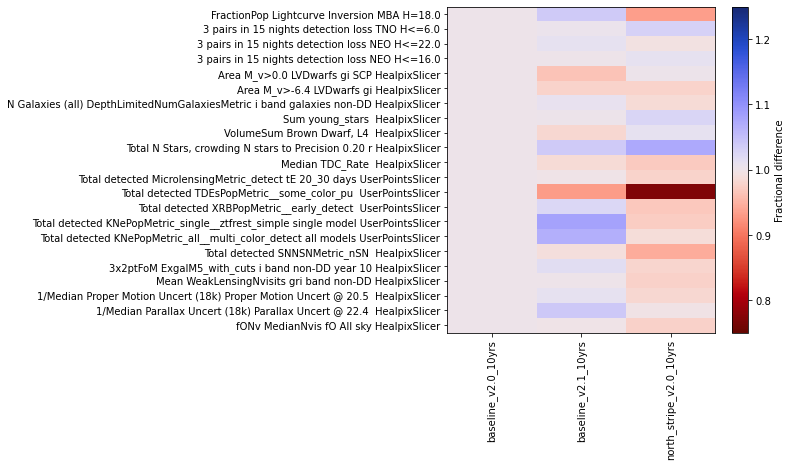

In [52]:
# There are many metrics that should be considered in addition to these, but these may point some potential issues
# Generally, a 3.5% decrease in the total number of visits for the "rest of the survey" isn't a huge impact, but 
# is noticeable (note that the TDE metric shows a lot of variability in general, 
# but the remainder of the metrics show <5% impacts, which is in line with the expected shift due to 3.5% visits)
msub = metric_sets.loc['SCOC']
fig, ax = maf.plot_run_metric_mesh(summaries.loc[runs, msub['metric']],
                                   baseline_run='baseline_v2.0_10yrs',
                                   metric_set=msub,
                                   color_range=0.5)